In [1]:
!pip install torch torchvision tqdm pandas pillow matplotlib seaborn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
from google.colab import drive, files
from IPython.display import display, HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def normalize_rc_value(value):
    """Normalize RC values from [1000-2000] range to [-1,1] range"""
    return (value - 1500) / 500

def denormalize_rc_value(value):
    """Convert normalized [-1,1] value back to RC [1000-2000] range"""
    return (value * 500) + 1500

In [4]:
# Cell 4: Dataset Class with File Checking
class RCCarDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        # Read CSV and extract timestamp and RC values
        self.data = pd.read_csv(csv_file, header=None,
                               names=['timestamp', 'steering', 'throttle'])

        # Filter out rows with missing images
        valid_rows = []
        for idx, row in self.data.iterrows():
            # Add video_capture_ prefix and .jpg extension
            img_path = os.path.join(img_dir, f"video_capture_{row['timestamp']}.jpg")
            if os.path.exists(img_path):
                valid_rows.append(idx)

        # Keep only valid rows
        self.data = self.data.loc[valid_rows].reset_index(drop=True)
        print(f"Kept {len(self.data)} valid samples out of {len(self.data)} total")

        # Normalize RC values
        self.data['steering'] = self.data['steering'].apply(normalize_rc_value)
        self.data['throttle'] = self.data['throttle'].apply(normalize_rc_value)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Construct image path from timestamp with video_capture_ prefix
        timestamp = self.data.iloc[idx]['timestamp']
        img_name = os.path.join(self.img_dir, f"video_capture_{timestamp}.jpg")

        try:
            # Load and transform image
            image = Image.open(img_name)
            if self.transform:
                image = self.transform(image)

            # Get normalized control values
            controls = torch.tensor([
                self.data.iloc[idx]['steering'],
                self.data.iloc[idx]['throttle']
            ], dtype=torch.float32)

            return image, controls

        except Exception as e:
            print(f"Error loading image {img_name}: {str(e)}")
            # Return a random valid sample instead
            return self.__getitem__(np.random.randint(len(self)))

    def get_sample(self, idx):
        """Get an untransformed sample for visualization"""
        timestamp = self.data.iloc[idx]['timestamp']
        img_name = os.path.join(self.img_dir, f"video_capture_{timestamp}.jpg")

        try:
            image = Image.open(img_name)
            controls = {
                'steering': denormalize_rc_value(self.data.iloc[idx]['steering']),
                'throttle': denormalize_rc_value(self.data.iloc[idx]['throttle'])
            }
            return image, controls
        except Exception as e:
            print(f"Error loading image {img_name}: {str(e)}")
            return self.get_sample(np.random.randint(len(self)))

In [5]:
# Cell 5: Data Visualization Functions
def plot_sample(dataset, idx):
    image, controls = dataset.get_sample(idx)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Camera Image')

    # Plot controls
    controls_df = pd.DataFrame({
        'Control': ['Steering', 'Throttle'],
        'Value': [controls['steering'], controls['throttle']]
    })

    sns.barplot(data=controls_df, x='Control', y='Value', ax=ax2)
    ax2.axhline(y=1500, color='r', linestyle='--', alpha=0.5)
    ax2.set_ylim(1000, 2000)
    ax2.set_title('Control Values')

    plt.tight_layout()
    plt.show()

# Cell 6: Visualize Sample Data
def visualize_samples(dataset, num_samples=3):
    for _ in range(num_samples):
        idx = np.random.randint(len(dataset))
        plot_sample(dataset, idx)

In [6]:
# Cell 6: Visualize Sample Data
def visualize_samples(dataset, num_samples=3):
    for _ in range(num_samples):
        idx = np.random.randint(len(dataset))
        plot_sample(dataset, idx)

In [7]:
# Cell 7: Model Architecture
class RCCarNet(nn.Module):
    def __init__(self):
        super(RCCarNet, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, 5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(24)
        self.bn2 = nn.BatchNorm2d(36)
        self.bn3 = nn.BatchNorm2d(48)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 2)  # 2 outputs: steering and throttle

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # CNN feature extraction with batch normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))  # tanh to bound outputs to [-1, 1]

        return x

In [8]:
# Cell: Dataset Diagnostics
def diagnose_dataset(csv_path, img_dir):
    # Read CSV
    df = pd.read_csv(csv_path, header=None, names=['timestamp', 'steering', 'throttle'])
    print(f"\nTotal entries in CSV: {len(df)}")
    print("\nFirst few CSV entries:")
    print(df.head())

    # List image files
    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    print(f"\nTotal images found: {len(image_files)}")
    print("\nFirst few image files:")
    print(image_files[:5])

    # Compare formats
    if len(image_files) > 0:
        print("\nExample image filename:", image_files[0])
    if len(df) > 0:
        print("Example CSV timestamp:", df['timestamp'].iloc[0])

    # Check for any images that match
    matches = 0
    for timestamp in df['timestamp']:
        img_path = os.path.join(img_dir, f"{timestamp}.jpg")
        if os.path.exists(img_path):
            matches += 1

    print(f"\nFound {matches} matching images out of {len(df)} CSV entries")

# Run diagnostics
print("Data Directory Contents:")
print(os.listdir(DATA_DIR))
print("\nImage Directory Contents:")
print(os.listdir(IMG_DIR)[:5], "...")

diagnose_dataset(CSV_PATH, IMG_DIR)

Data Directory Contents:


NameError: name 'DATA_DIR' is not defined

In [9]:
# Cell 8: Training Setup and Verification
def verify_dataset(csv_path, img_dir):
    """Verify and clean the dataset before training"""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")

    print(f"Found CSV file: {csv_path}")
    print(f"Found image directory: {img_dir}")

# Set your paths here
DATA_DIR = '/content/drive/MyDrive/Image_Data_20240929'
CSV_PATH = os.path.join(DATA_DIR, 'rc_channels_2025_02_01.csv')
IMG_DIR = os.path.join(DATA_DIR, 'image_data')

# Verify dataset
verify_dataset(CSV_PATH, IMG_DIR)

# Create data transformations
transform = transforms.Compose([
    transforms.Resize((66, 200)),  # NVIDIA model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create dataset with automatic filtering of missing files
full_dataset = RCCarDataset(CSV_PATH, IMG_DIR, transform=transform)

# Only proceed if we have enough valid samples
if len(full_dataset) < 100:  # Arbitrary minimum threshold
    raise ValueError(f"Not enough valid samples in dataset: {len(full_dataset)}")

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Found CSV file: /content/drive/MyDrive/Image_Data_20240929/rc_channels_2025_02_01.csv
Found image directory: /content/drive/MyDrive/Image_Data_20240929/image_data
Kept 12654 valid samples out of 12654 total
Using device: cuda


In [12]:
# Cell 9: Training Functions
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.grid(True)
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    # Create save directory in Google Drive
    save_dir = os.path.join(DATA_DIR, 'trained_models')
    os.makedirs(save_dir, exist_ok=True)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}')

        for images, controls in train_bar:
            images = images.to(device)
            controls = controls.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, controls)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}')

        with torch.no_grad():
            for images, controls in val_bar:
                images = images.to(device)
                controls = controls.to(device)

                outputs = model(images)
                loss = criterion(outputs, controls)
                val_loss += loss.item()
                val_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')

        # Save model to Google Drive
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_path = os.path.join(save_dir, 'best_rc_car_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'history': history
            }, save_path)
            print(f'Saved new best model to {save_path}!')

        # Save checkpoint every 1 epochs
        if (epoch + 1) % 1 == 0:
            checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'history': history
            }, checkpoint_path)
            print(f'Saved checkpoint to {checkpoint_path}')

    # Save final model
    final_path = os.path.join(save_dir, 'final_rc_car_model.pth')
    torch.save({
        'epoch': num_epochs-1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'history': history
    }, final_path)
    print(f'Saved final model to {final_path}')

    return history

In [13]:
# Cell 10: Initialize and Train Model
model = RCCarNet()
history = train_model(model, train_loader, val_loader, num_epochs=3)


Training Epoch 1/3:   0%|          | 0/317 [00:00<?, ?it/s]

Validation Epoch 1/3:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/3:
Training Loss: 0.1211
Validation Loss: 0.0935
Saved new best model to /content/drive/MyDrive/Image_Data_20240929/trained_models/best_rc_car_model.pth!
Saved checkpoint to /content/drive/MyDrive/Image_Data_20240929/trained_models/checkpoint_epoch_1.pth


Training Epoch 2/3:   0%|          | 0/317 [00:00<?, ?it/s]

Validation Epoch 2/3:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/3:
Training Loss: 0.0943
Validation Loss: 0.0856
Saved new best model to /content/drive/MyDrive/Image_Data_20240929/trained_models/best_rc_car_model.pth!
Saved checkpoint to /content/drive/MyDrive/Image_Data_20240929/trained_models/checkpoint_epoch_2.pth


Training Epoch 3/3:   0%|          | 0/317 [00:00<?, ?it/s]

Validation Epoch 3/3:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/3:
Training Loss: 0.0804
Validation Loss: 0.0779
Saved new best model to /content/drive/MyDrive/Image_Data_20240929/trained_models/best_rc_car_model.pth!
Saved checkpoint to /content/drive/MyDrive/Image_Data_20240929/trained_models/checkpoint_epoch_3.pth
Saved final model to /content/drive/MyDrive/Image_Data_20240929/trained_models/final_rc_car_model.pth


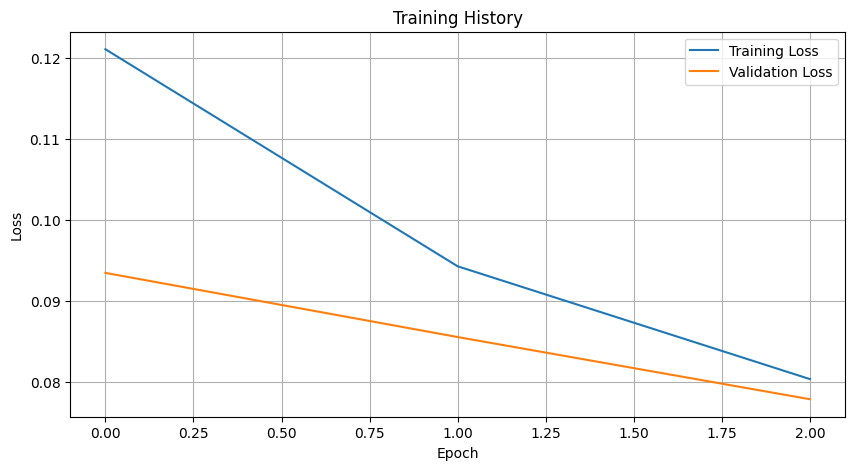

In [14]:
# Cell 11: Plot Training History
plot_training_history(history)